In [1]:
import pandas as pd 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
folder = "/media/riannek/minimax/gleis/speed_run24-sklearn"
df = pd.read_csv(os.path.join(folder, 'speedlog.csv'))
df['file'] = df['file'].fillna("")
df['file'] = df['file'].apply(lambda x: os.path.basename(x))
df['what'] = df['what'].replace({'voxelfilter': 'Voxelfilter', 'Growing lines': 'Linienbildung', 'Central points': 'Gleiserkennung', 'read': 'Lesen'})
df.head()


,what,file,time,points
0,Lesen,4475525_5341275.copc.laz,0.556898,1298026
1,Voxelfilter,4475525_5341275.copc.laz,2.836546,145607
2,Lesen,4475625_5341350.copc.laz,0.152364,268017
3,Voxelfilter,4475625_5341350.copc.laz,0.687531,28071
4,Lesen,4478600_5350025.copc.laz,0.123070,192602


Gesamtzeit

In [24]:
minutes_total = df['time'].sum() / 60 
minutes_total // 60, minutes_total % 60

(np.float64(3.0), np.float64(59.8637828071912))

Voxelfilter ist hier ohne read:

In [3]:
grouped = df.groupby('what')['time'].sum()  / 60
grouped  

what
Gleiserkennung        102.852944
Lesen                  27.421578
Linienbildung          13.775672
Points with margin      0.000000
Seed points             0.000000
Voxelfilter            95.813588
Name: time, dtype: float64

In [1]:
1000/240

4.166666666666667

In [4]:
grouped['Voxelfilter'] = grouped['Voxelfilter'] + grouped['Lesen'] 
read = grouped['Lesen']
grouped = grouped.drop('Lesen')
grouped = grouped[grouped > 0]

In [5]:
grouped  

what
Gleiserkennung    102.852944
Linienbildung      13.775672
Voxelfilter       123.235166
Name: time, dtype: float64

In [6]:
grouped * 100 / grouped.sum()

what
Gleiserkennung    42.879731
Linienbildung      5.743123
Voxelfilter       51.377146
Name: time, dtype: float64

In [7]:
read * 100 / grouped.sum()

np.float64(11.432146054392039)

In [8]:
read * 100 / grouped['Voxelfilter']

np.float64(22.251422910075437)

In [9]:
grouped.sum() // 60, grouped.sum() % 60

(np.float64(3.0), np.float64(59.8637828071912))

In [10]:
custom_order = ['Voxelfilter', 'Gleiserkennung' ,'Linienbildung']
grouped = grouped.loc[custom_order]

(np.float64(-1.0999998138755098),
 np.float64(1.0999967413429566),
 np.float64(-1.0999998304380172),
 np.float64(1.0999999919256198))

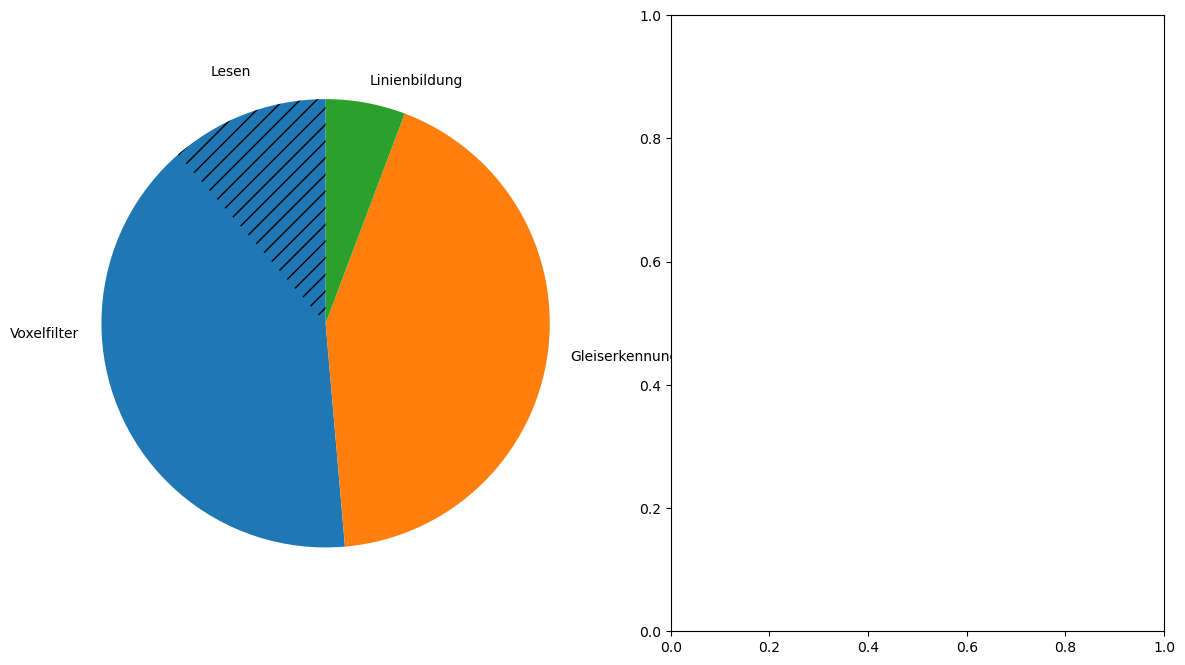

In [11]:

# Prepare data
labels = grouped.index
sizes = grouped.values

# Pie chart
fig, ax = plt.subplots(1,2, figsize=(14, 8))
wedges, texts = ax[0].pie(sizes, labels=labels, startangle=90)

# Find index of the combined category
combined_index = list(labels).index('Voxelfilter')

# Overlay the "hatched" part (e.g., 'bar') manually
# Calculate angle for the segment
angle = 360 * read / grouped.sum()

# Determine where the wedge starts
startangle = 90  # if same as above
angle_offset = sum(sizes[:combined_index]) / sizes.sum() * 360

# Draw a hatched wedge manually
from matplotlib.patches import Wedge

theta1=startangle + angle_offset
theta2=theta1 + angle
theta_mid = (theta1 + theta2) / 2

hatch_wedge = Wedge(center=(0, 0),
                    r=1, #0.95,  # slightly smaller
                    theta1=theta1,
                    theta2=theta2,
                    facecolor='none',
                    hatch='//',
                    edgecolor='black',
                    linewidth=0)

ax[0].add_patch(hatch_wedge)

# Convert polar to cartesian for label position
r = 1.2  # radius slightly outside the wedge
x = r * np.cos(np.deg2rad(theta_mid))
y = r * np.sin(np.deg2rad(theta_mid))

# Add the label manually
ax[0].text(x, y, 'Lesen', ha='center', va='center')

ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.



In [12]:
linelayer = gpd.read_file(os.path.join(folder, 'temp.gpkg'), layer='centerlines')
linelayer.head()

,used,geometry
0,0,"LINESTRING Z (4476157.809 5342334.019 485.047,..."
1,0,"LINESTRING Z (4476157.809 5342334.019 485.047,..."
2,1,"LINESTRING Z (4474825.226 5340468.253 503.113,..."
3,1,"LINESTRING Z (4476144.902 5342268.597 485.371,..."
4,1,"LINESTRING Z (4476474.53 5343841.848 486.476, ..."


In [13]:
linelayer['num_points'] = linelayer.geometry.apply(lambda geom: len(geom.coords))
linelayer.head()

,used,geometry,num_points
0,0,"LINESTRING Z (4476157.809 5342334.019 485.047,...",2673
1,0,"LINESTRING Z (4476157.809 5342334.019 485.047,...",824
2,1,"LINESTRING Z (4474825.226 5340468.253 503.113,...",2593
3,1,"LINESTRING Z (4476144.902 5342268.597 485.371,...",1852
4,1,"LINESTRING Z (4476474.53 5343841.848 486.476, ...",238


In [14]:
linelayer['num_points'].describe()

count      153.000000
mean       503.797386
std       1287.095012
min          9.000000
25%         38.000000
50%        112.000000
75%        344.000000
max      10766.000000
Name: num_points, dtype: float64

In [15]:
linepointsum = linelayer['num_points'].sum()
linepointsum  

np.int64(77081)

In [16]:
df['what2'] = df['what'].replace({'Lesen': 'Punktwolke', 'Seed points': 'Saatpunkte', 'GrowingLines': 'Stützpunkte', 'Gleiserkennung': 'Punkte Gleismitte'})
punktzahl = df.groupby('what2')['points'].sum()
punktzahl 

what2
Linienbildung                  0
Points with margin     264930110
Punkte Gleismitte         346371
Punktwolke            3715574762
Saatpunkte                698779
Voxelfilter            199271321
Name: points, dtype: int64

In [17]:
print(punktzahl.to_latex())

\begin{tabular}{lr}
\toprule
 & points \\
what2 &  \\
\midrule
Linienbildung & 0 \\
Points with margin & 264930110 \\
Punkte Gleismitte & 346371 \\
Punktwolke & 3715574762 \\
Saatpunkte & 698779 \\
Voxelfilter & 199271321 \\
\bottomrule
\end{tabular}



In [18]:
punktzahl['Stützpunkte'] = linepointsum
punktzahl.drop('Points with margin', inplace=True)

custom_order = ['Punktwolke', 'Voxelfilter', 'Saatpunkte', 'Punkte Gleismitte', 'Stützpunkte']
punktzahl = punktzahl.loc[custom_order] 
punktzahl 

what2
Punktwolke           3715574762
Voxelfilter           199271321
Saatpunkte               698779
Punkte Gleismitte        346371
Stützpunkte               77081
Name: points, dtype: int64

In [19]:
punktzahl['Punktwolke'] / punktzahl['Saatpunkte']

np.float64(5317.2387292691965)

Text(-0.1, 1.05, 'b)')

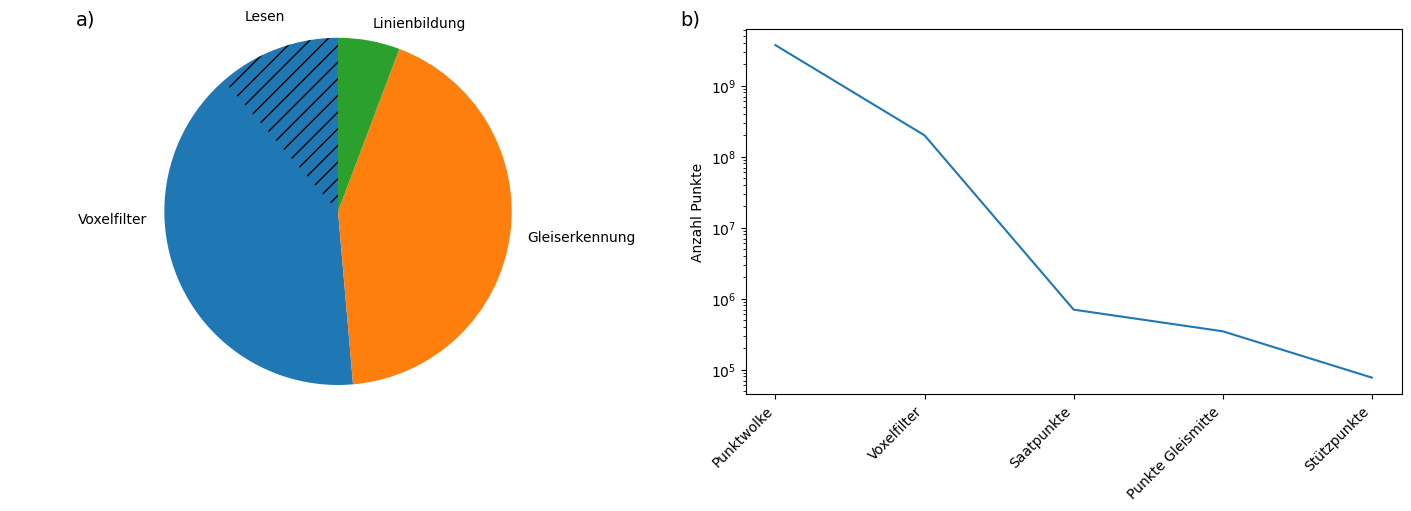

In [20]:

# Prepare data
labels = grouped.index
sizes = grouped.values

# Pie chart
fig, ax = plt.subplots(1,2, figsize=(14, 5), constrained_layout=True)
wedges, texts = ax[0].pie(sizes, labels=labels, startangle=90)

# Find index of the combined category
combined_index = list(labels).index('Voxelfilter')

# Overlay the "hatched" part (e.g., 'bar') manually
# Calculate angle for the segment
angle = 360 * read / grouped.sum()

# Determine where the wedge starts
startangle = 90  # if same as above
angle_offset = sum(sizes[:combined_index]) / sizes.sum() * 360

# Draw a hatched wedge manually
from matplotlib.patches import Wedge

theta1=startangle + angle_offset
theta2=theta1 + angle
theta_mid = (theta1 + theta2) / 2

hatch_wedge = Wedge(center=(0, 0),
                    r=1, #0.95,  # slightly smaller
                    theta1=theta1,
                    theta2=theta2,
                    facecolor='none',
                    hatch='//',
                    edgecolor='black',
                    linewidth=0)

ax[0].add_patch(hatch_wedge)

# Convert polar to cartesian for label position
r = 1.2  # radius slightly outside the wedge
x = r * np.cos(np.deg2rad(theta_mid))
y = r * np.sin(np.deg2rad(theta_mid))

# Add the label manually
ax[0].text(x, y, 'Lesen', ha='center', va='center')

ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax[1].plot(punktzahl.index, punktzahl.values)
ax[1].set_yscale('log')
ax[1].set_ylabel('Anzahl Punkte')
#ax[1].set_xlabel('Bearbeitungsschritt')
# ax[1].tick_params(axis='x', labelrotation=45)
for label in ax[1].get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')  # move anchor to the left of the label
    label.set_verticalalignment('top')      # optional: improves baseline alignment

ax[0].text(0.1, 1.05, 'a)', transform=ax[0].transAxes,
           fontsize=14, va='top', ha='left')

ax[1].text(-0.1, 1.05, 'b)', transform=ax[1].transAxes,
           fontsize=14, va='top', ha='left')

In [25]:
fig.savefig('speed_pie_chart_sklearn.png', dpi=300, bbox_inches='tight')

In [22]:
30/80

0.375